<a href="https://colab.research.google.com/github/pranavrao87/Classification-Models/blob/main/pneumonia_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pneumonia Binary Classification using a Kaggle Dataset and TinyVGG Architecture

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
# Upload Kaggle API Token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prao87","key":"a2bfa89f6777d72984cd8afdc6adbc10"}'}

In [2]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [3]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:17<00:00, 173MB/s]
100% 2.29G/2.29G [00:17<00:00, 141MB/s]


In [4]:
# Extract and unzip file
zip_ref = zipfile.ZipFile("/content/chest-xray-pneumonia.zip")
zip_ref.extractall()
zip_ref.close()

In [5]:
# Walking through the dataset
for dirpath, dirnames, filenames in os.walk("chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 5 directories and 0 images in 'chest_xray'.
There are 3 directories and 1 images in 'chest_xray/chest_xray'.
There are 2 directories and 1 images in 'chest_xray/chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/chest_xray/test/NORMAL'.
There are 2 directories and 1 images in 'chest_xray/chest_xray/val'.
There are 0 directories and 9 images in 'chest_xray/chest_xray/val/PNEUMONIA'.
There are 0 directories and 9 images in 'chest_xray/chest_xray/val/NORMAL'.
There are 2 directories and 1 images in 'chest_xray/chest_xray/train'.
There are 0 directories and 3876 images in 'chest_xray/chest_xray/train/PNEUMONIA'.
There are 0 directories and 1342 images in 'chest_xray/chest_xray/train/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/test/N

In [6]:
import shutil

shutil.rmtree('/content/chest_xray/__MACOSX', ignore_errors=True)
shutil.rmtree('/content/chest_xray/chest_xray', ignore_errors=True)

In [7]:
# Walking through the dataset
for dirpath, dirnames, filenames in os.walk("chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'chest_xray'.
There are 2 directories and 0 images in 'chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/test/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/val'.
There are 0 directories and 8 images in 'chest_xray/val/PNEUMONIA'.
There are 0 directories and 8 images in 'chest_xray/val/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/train'.
There are 0 directories and 3875 images in 'chest_xray/train/PNEUMONIA'.
There are 0 directories and 1341 images in 'chest_xray/train/NORMAL'.


## Visualizing Data

In [8]:
from re import A
# Visualize the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory
  target_folder = target_dir + "/" + target_class

  # Get rand image path
  random_image = random.sample(os.listdir(target_folder), 1) # randomly sample 1 of the items from here
  print(random_image)
  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show shape of image

  return img

In [9]:
# Setting up the train and test directories
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"

In [10]:
# Getting class names (subdirectories)
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted(item.name for item in data_dir.glob('*')))
print(class_names)

['NORMAL' 'PNEUMONIA']


['NORMAL2-IM-0915-0001.jpeg']
Image shape: (1036, 1276)


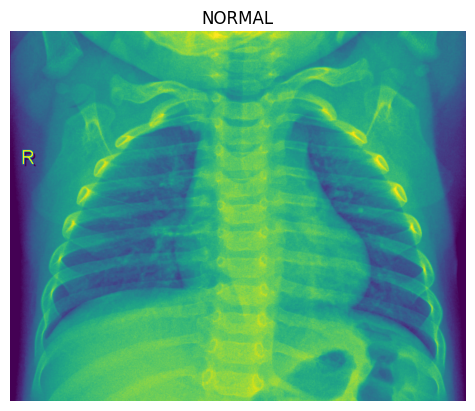

In [11]:
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

## Baseline model (limited data pre-processing)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Activation
from tensorflow.keras.optimizers import Adam


In [13]:
# Creating the data loaders or data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary')

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')


val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Running the model w/ test_data as validation b/c val data set is rly small and not good

In [14]:
model_1 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_1.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=len(test_data))

Epoch 1/5
163/163 [==============================] - 65s 322ms/step - loss: 0.2487 - accuracy: 0.8915 - val_loss: 0.9316 - val_accuracy: 0.7276
Epoch 2/5
163/163 [==============================] - 51s 315ms/step - loss: 0.1129 - accuracy: 0.9567 - val_loss: 0.9367 - val_accuracy: 0.7548
Epoch 3/5
163/163 [==============================] - 51s 314ms/step - loss: 0.0800 - accuracy: 0.9709 - val_loss: 1.0097 - val_accuracy: 0.7308
Epoch 4/5
163/163 [==============================] - 51s 316ms/step - loss: 0.0635 - accuracy: 0.9776 - val_loss: 0.6837 - val_accuracy: 0.8013
Epoch 5/5
163/163 [==============================] - 51s 310ms/step - loss: 0.0480 - accuracy: 0.9847 - val_loss: 1.1465 - val_accuracy: 0.7644


In [15]:
model_1.evaluate(test_data)

20/20 [==============================] - 4s 221ms/step - loss: 1.1465 - accuracy: 0.7644


[1.146547555923462, 0.7644230723381042]

In [16]:
# Plot validation and training curves
def plot_loss_curves(history):
  """
  Returns seperte loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs were ran

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

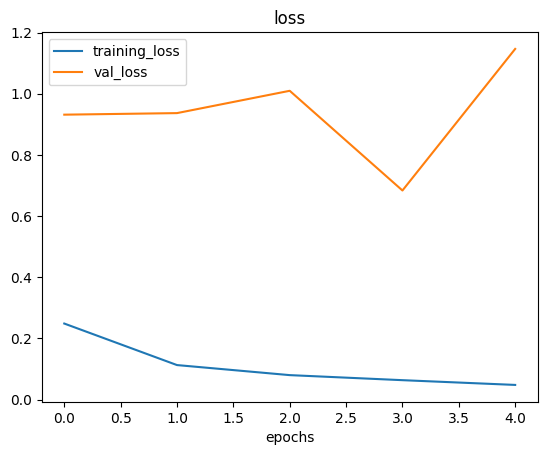

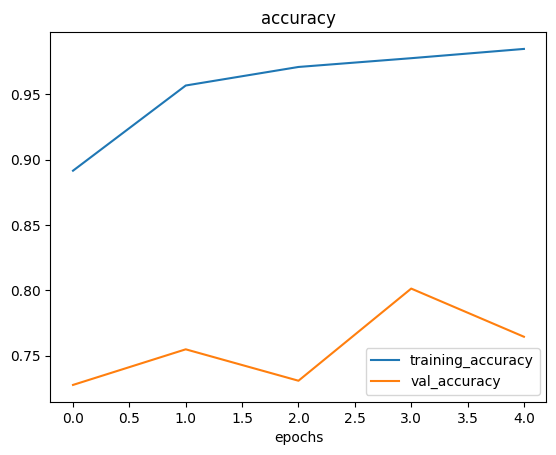

In [17]:
plot_loss_curves(history_1)

Very high training accuracy, but very low test accuracy therefore the model is overfitting

## Data pre-processing

First experiment : Reconfigure the data split

In [18]:
# Walking through the dataset
for dirpath, dirnames, filenames in os.walk("chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'chest_xray'.
There are 2 directories and 0 images in 'chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/test/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/val'.
There are 0 directories and 8 images in 'chest_xray/val/PNEUMONIA'.
There are 0 directories and 8 images in 'chest_xray/val/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/train'.
There are 0 directories and 3875 images in 'chest_xray/train/PNEUMONIA'.
There are 0 directories and 1341 images in 'chest_xray/train/NORMAL'.


In [19]:
390 + 8 + 3875

4273

In [20]:
1341 + 234 + 8

1583

*   Training: 80%
*   Test: 10%
*   Val: 10%

### Pneumonia images

In [21]:
0.8 * 4273

3418.4

In [22]:
0.1 * 4273

427.3

In [23]:
3875-3418
# 457 extra in training

457

In [24]:
427 - 390

37

In [25]:
457-37

420

roughly 37 images moved from train to test for pneumonia

rest 420 images get moved from training to validation set for penumonia

### Normal images

In [26]:
0.8 * 1583

1266.4

In [27]:
0.1 * 1583

158.3

In [28]:
1341 - 1266
# 75 extra images in training

75

In [29]:
234 - 158
# 76 extra images in testing

76

In [30]:
75+76+8

159

75 images from train to val for normal


76 images from test to val for normal

### Sort the images

Evening the ditribution for the training, testing, and val sets

In [31]:
# Moving files to extra folder to even out the image datasets
import random
def move_random_images(source, dest, num_files):
  files = os.listdir(source)
  for file_name in random.sample(files, num_files):
    shutil.move(os.path.join(source, file_name), dest)

In [32]:
# Pneumonia
move_random_images(source="chest_xray/train/PNEUMONIA", dest="chest_xray/test/PNEUMONIA", num_files=37)
move_random_images(source="chest_xray/train/PNEUMONIA", dest="chest_xray/val/PNEUMONIA", num_files=420)

# Normal
move_random_images("chest_xray/train/NORMAL", "chest_xray/val/NORMAL", 75)
move_random_images("chest_xray/test/NORMAL", "chest_xray/val/NORMAL", 76)


In [33]:
# Walk through re-organize dataset
for dirpath, dirnames, filenames in os.walk("chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'chest_xray'.
There are 2 directories and 0 images in 'chest_xray/test'.
There are 0 directories and 427 images in 'chest_xray/test/PNEUMONIA'.
There are 0 directories and 158 images in 'chest_xray/test/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/val'.
There are 0 directories and 428 images in 'chest_xray/val/PNEUMONIA'.
There are 0 directories and 159 images in 'chest_xray/val/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/train'.
There are 0 directories and 3418 images in 'chest_xray/train/PNEUMONIA'.
There are 0 directories and 1266 images in 'chest_xray/train/NORMAL'.


## Model 2

redistributed the images amongs the training, testing, and validation sets. (80/10/10 split)

In [34]:
# Creating the data loaders or data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary')

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')


val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='binary')

Found 4684 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


In [35]:
model_2 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_2.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/5
147/147 [==============================] - 51s 326ms/step - loss: 0.2933 - accuracy: 0.8683 - val_loss: 0.4141 - val_accuracy: 0.8603
Epoch 2/5
147/147 [==============================] - 46s 312ms/step - loss: 0.1148 - accuracy: 0.9590 - val_loss: 0.5301 - val_accuracy: 0.8859
Epoch 3/5
147/147 [==============================] - 47s 318ms/step - loss: 0.0889 - accuracy: 0.9695 - val_loss: 0.3553 - val_accuracy: 0.8927
Epoch 4/5
147/147 [==============================] - 47s 320ms/step - loss: 0.0688 - accuracy: 0.9772 - val_loss: 0.5938 - val_accuracy: 0.8893
Epoch 5/5
147/147 [==============================] - 47s 322ms/step - loss: 0.0735 - accuracy: 0.9720 - val_loss: 0.6361 - val_accuracy: 0.8790


In [36]:
model_2.evaluate(test_data)

19/19 [==============================] - 4s 216ms/step - loss: 0.9687 - accuracy: 0.8068


[0.9687281847000122, 0.8068376183509827]

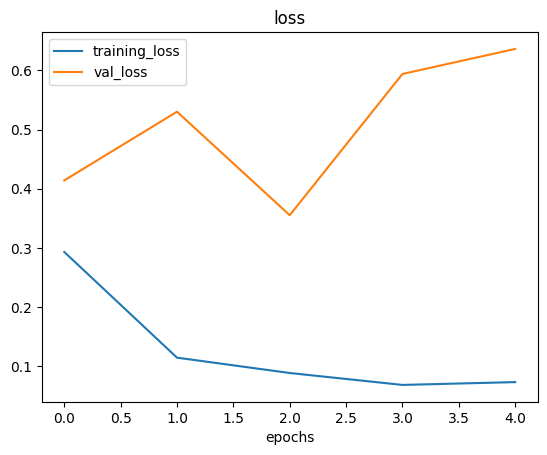

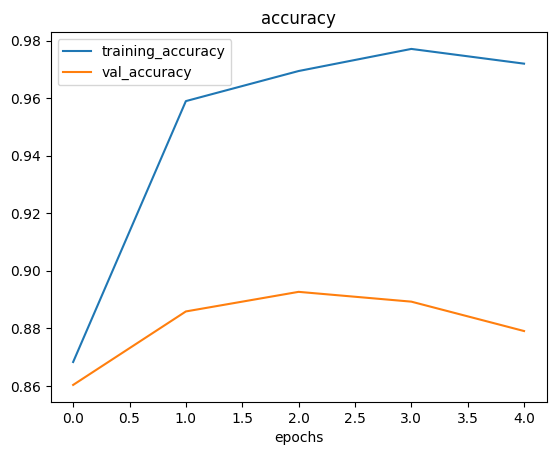

In [37]:
plot_loss_curves(history_2)

## Data Augmentation

In [38]:
# Re-instantiate w/ augmented training data
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                          rotation_range=0.2,
                                          zoom_range=0.2,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          horizontal_flip=True)

train_data_aug = train_datagen_augmented.flow_from_directory(train_dir,
                                                             target_size=(224, 224),
                                                             batch_size=32,
                                                             class_mode="binary")

Found 4684 images belonging to 2 classes.


In [39]:
model_3 = tf.keras.models.clone_model(model_2)

model_3.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_3 = model_3.fit(train_data_aug,
                        epochs=5,
                        steps_per_epoch=len(train_data_aug),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/5
147/147 [==============================] - 94s 621ms/step - loss: 0.4465 - accuracy: 0.7829 - val_loss: 0.4058 - val_accuracy: 0.8245
Epoch 2/5
147/147 [==============================] - 93s 630ms/step - loss: 0.3183 - accuracy: 0.8576 - val_loss: 0.3576 - val_accuracy: 0.8399
Epoch 3/5
147/147 [==============================] - 92s 623ms/step - loss: 0.2922 - accuracy: 0.8721 - val_loss: 0.3316 - val_accuracy: 0.8518
Epoch 4/5
147/147 [==============================] - 92s 625ms/step - loss: 0.2681 - accuracy: 0.8866 - val_loss: 0.3303 - val_accuracy: 0.8654
Epoch 5/5
147/147 [==============================] - 91s 620ms/step - loss: 0.2804 - accuracy: 0.8783 - val_loss: 0.3158 - val_accuracy: 0.8603


In [40]:
model_3.evaluate(test_data)

19/19 [==============================] - 4s 205ms/step - loss: 0.3722 - accuracy: 0.8308


[0.3722158372402191, 0.8307692408561707]

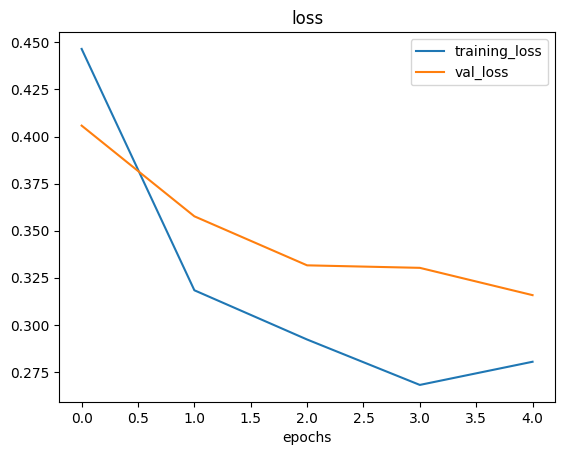

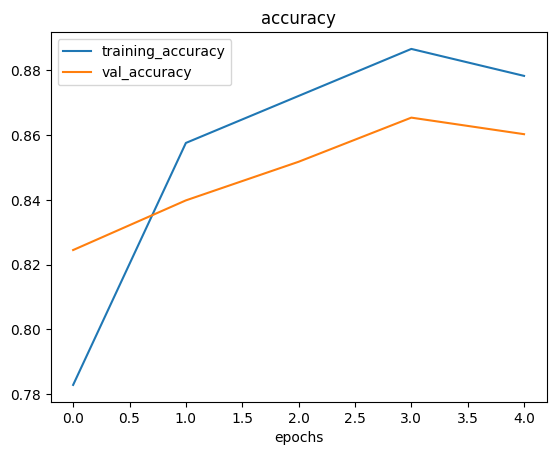

In [41]:
plot_loss_curves(history_3)

In [42]:
model_4 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_4.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_4 = model_4.fit(train_data_aug,
                        epochs=5,
                        steps_per_epoch=len(train_data_aug),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/5
147/147 [==============================] - 91s 607ms/step - loss: 0.4844 - accuracy: 0.7585 - val_loss: 0.3508 - val_accuracy: 0.8313
Epoch 2/5
147/147 [==============================] - 89s 607ms/step - loss: 0.3373 - accuracy: 0.8529 - val_loss: 0.3151 - val_accuracy: 0.8654
Epoch 3/5
147/147 [==============================] - 89s 605ms/step - loss: 0.3151 - accuracy: 0.8602 - val_loss: 0.3041 - val_accuracy: 0.8773
Epoch 4/5
147/147 [==============================] - 89s 606ms/step - loss: 0.2876 - accuracy: 0.8807 - val_loss: 0.3214 - val_accuracy: 0.8654
Epoch 5/5
147/147 [==============================] - 89s 605ms/step - loss: 0.2720 - accuracy: 0.8864 - val_loss: 0.3556 - val_accuracy: 0.8552


In [43]:
model_4.evaluate(test_data)

19/19 [==============================] - 5s 244ms/step - loss: 0.3820 - accuracy: 0.8308


[0.3819727599620819, 0.8307692408561707]

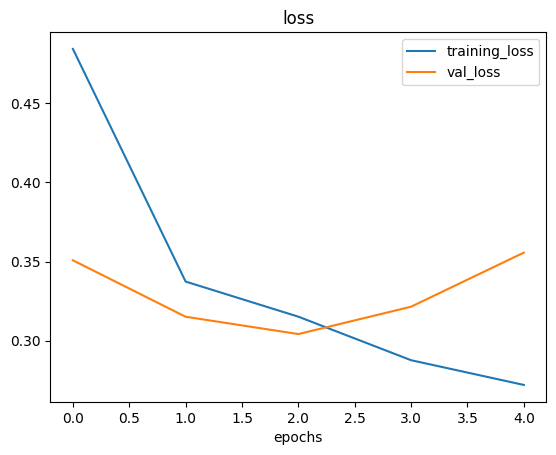

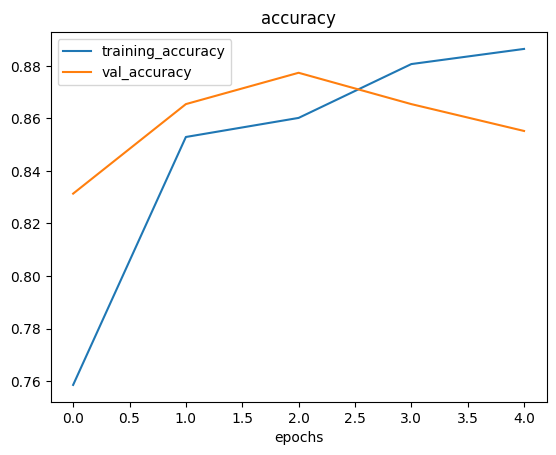

In [44]:
plot_loss_curves(history_4)